# Setup and Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set
import warnings
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import ParameterSampler
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense
from keras.models import Model
from keras.layers import Input
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers.merge import concatenate
from keras.optimizers import adam_v2, rmsprop_v2
from keras.optimizers import gradient_descent_v2
from keras.callbacks import EarlyStopping


#Custom Python Module with functions specifically for this project
import ChicagoDataCleaningFunctions as cd
#Custom Python Module to fetch the data
import FetchChicagoData as fc

# Get the Data

In [3]:
%%time
#Specify input values for fetching the data
query = """
            SELECT unique_key, date, primary_type, location_description, 
                    arrest, domestic, community_area, year
            FROM `gdac-327115.Chicago.chicago2`
            WHERE year >= 2011
        """
project_id = "gdac-327115"
excel_file = "ChicagoCommunityAreas.xlsx"

#Fetch the data
chicago = fc.fetch_chicago_data(query, project_id, excel_file, verbose=True)

Fetching Chicago Data Started...

Successfully queried Google BigQuery.
Sucessfully read in excel file.
Sucessfully joined Chicago districts to main data.
Successfully dropped duplicate column

Succcessfully fetched Chicago Data
Wall time: 3min 21s


# Split the Data into Training and Test Sets

In [4]:
chicago_train = chicago.loc[chicago["year"] != 2021]
chicago_test = chicago.loc[chicago["year"] == 2021]

# Clean the Training Data

In [5]:
%%capture --no-stdout
cd.chicago_data_cleaner(chicago_train, verbose=True)

Cleaning Started...

Successfully Cleaned Primary Type
Successfully Imputed Location
Successfully Cleaned Location
Successfully Added Month Column
Successfully Added Hour Column
Successfully Cleaned Community

Data Set Successfully Cleaned!


# Prepare the Data

Since we are focusing on using deep learning techniques, we do more than just one hot encoding the variables. Instead, we'll use embeddings to encode the features.

In [6]:
def data_to_array(df, attribs):
    """
    This function converts the dataframe into numpy arrays based on specified attributes. 
    
    df: Pandas dataframe
    attribs: List of columns to use as attributes
    
    returns: X, y numpy arrays
    """
    X = df[attribs].values
    y = df["arrest"].values
    
    return X, y

In [7]:
def prepare_inputs(X_train, X_test):
    """
    This function prepares the input data by ordinal encoding each one and adding it to a list.
    
    X_train: Array of training features
    X_test: Array of test features
    
    returns: Two lists of encoded training and test features
    """
    X_train_enc, X_test_enc = list(), list()
    # label encode each column
    for i in range(X_train.shape[1]):
        le = LabelEncoder()
        le.fit(X_train[:, i])
        # encode
        train_enc = le.transform(X_train[:, i])
        test_enc = le.transform(X_test[:, i])
        # store
        X_train_enc.append(train_enc)
        X_test_enc.append(test_enc)
    return X_train_enc, X_test_enc

In [8]:
def prepare_targets(y_train, y_test):
    """
    This function transforms the target by ordinal encoding the values. 
    
    y_train: Array of training targets
    y_test: Array of test targets
    
    returns: Two lists containing the transformed targets
    """
    le = LabelEncoder()
    le.fit(y_train)
    y_train_enc = le.transform(y_train)
    y_test_enc = le.transform(y_test)
    return y_train_enc, y_test_enc

In [9]:
def input_to_embedding(n_embeddings, training_encodings):
    """
    This function iterates through each variable and constructs and input layer and connects it to an embedding
    layer, and stores both layers in a list. 
        
    n_embeddings: Number of embedding dimensions
    training_encodings: List of training features
    
    returns:
        in_layers: List of input layers
        em_layers: List of embedding layers
    """
    in_layers = list()
    em_layers = list()
    for i in range(len(training_encodings)):
        #Calculate the number of unique inputs
        n_labels = len(np.unique(training_encodings[i]))
        #Define input layer
        in_layer = Input(shape=(1,))
        #Define embedding layer
        em_layer = Embedding(n_labels, n_embeddings)(in_layer)
        #Store layers
        in_layers.append(in_layer)
        em_layers.append(em_layer)
    return in_layers, em_layers


In [10]:
#Specify the features to use
features = ["primary_type", "location_description", "domestic", "district_name", "community_name", "Month", "Hour"]
#Transform the features and targets into arrays
X, y = data_to_array(chicago_train, features)
#Split the data twice to quickly train preliminary models
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = .80, random_state = 42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size =.10, random_state = 42, stratify = y_train)

In [10]:
#Check the shapes
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(506634, 7)
(56293, 7)
(506634,)
(56293,)


In [11]:
#Encode the training and target features
X_train_enc, X_val_enc = prepare_inputs(X_train, X_val)
#Encode the training and validation targets
y_train_enc, y_val_enc = prepare_targets(y_train, y_val)

# Baseline Model

Although no one will agree on what a "baseline" neural network model looks like, we can build a simple two layer model with 10 neurons in each layer using 10 as the dimension of the embeddings. The model will use the binary crossentropy loss with the adam optimizer and run for 10 epochs with a batch size of 32 using early stopping. 

In [93]:
input_layers, embed_layers = input_to_embedding(n_embeddings=10, training_encodings=X_train_enc)
input_ = keras.layers.concatenate(embed_layers)
hidden1 = Dense(10, activation='relu')(input_)
hidden2 = Dense(10, activation='relu')(hidden1)
output = Dense(1, activation='sigmoid')(hidden2)
baseline_model = Model(inputs=input_layers, outputs=output)
#Compile the keras model
baseline_model.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])

In [35]:
#Model architecture
print(baseline_model.summary())

Model: "model_101"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_708 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_709 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_710 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_711 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________

In [44]:
%%time
early = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 10, restore_best_weights=True)

history = baseline_model.fit(X_train_enc, y_train_enc, validation_split=.2, epochs=50, batch_size=32, verbose=0, callbacks = [early])

Wall time: 4min 46s


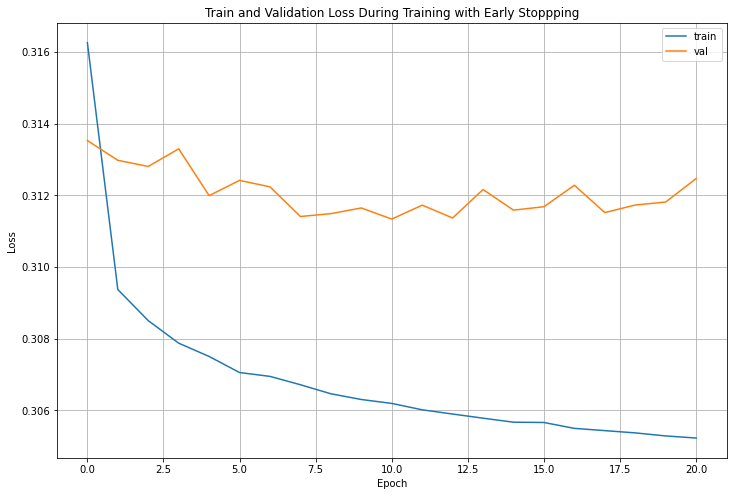

In [248]:
plt.figure(figsize = (12,8))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.grid(True)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train and Validation Loss During Training with Early Stoppping")
plt.legend()
plt.show()

In [243]:
#Baseline Accuracy and F1 Scores
y_pred = baseline_model.predict(X_val_enc)
#Change the prediction to form expected for accuracy and f1-score functions
y_pred = np.round(y_pred.reshape((y_pred.shape[0])))
#Change the validation targets 
y_val = y_val.astype(np.int)
model_base_acc = np.round(accuracy_score(y_pred, y_val), 4) * 100
model_base_f1 = np.round(f1_score(y_pred, y_val), 4) * 100
print(f"Model Baseline Accuracy Score: {model_base_acc:.2f}%")
print(f"Model Baseline F1-Score: {model_base_f1:.2f}%")

Model Baseline Accuracy Score: 87.70%
Model Baseline F1-Score: 69.11%


In [244]:
#Confusion matrix
confusion_matrix(y_pred, y_val)

array([[41622,  5700],
       [ 1224,  7747]], dtype=int64)

# Hyperparameter Tuning 

### Hyperparameter Considerations
<ul>
    <li>Number of layers</li>
        <ul>
            <li>5 - 15 layers</li>
        </ul>
    <li>Number of neurons per layer</li>
        <ul>
            <li>25 - 75 neurons</li>
        </ul>
    <li>Activation function</li>
        <ul>
            <li>SELU</li>
            <li>ELU</li>
            <li>ReLU</li>
        </ul>
    <li>Weight Initialization</li>
        <ul>
            <li>Glorot</li>
            <li>He</li>
            <li>LeCun</li>
        </ul>            
    <li>Learning rate</li>
    <li>Momentum</li>
    <li>Optimizer</li>
        <ul>
            <li>SGD with and without the nesterov acccelerated gradient method</li>
            <li>RMSProp</li>
            <li>Adam</li>
        </ul>
    <li>Regularization</li>
        <ul>
            <li>Early stopping</li>
            <li>Dropout</li>
        </ul>
</ul>

In [12]:
def build_model(n_embeddings = 10, n_hidden=1, n_neurons=5, lr_rate=3e-2, activation = "relu",
                drop_rate=.2, kernel = True, kernel_initializer = "he_normal", optimizer="Adam", 
                momentum = .9, nesterov = False, training_input=X_train_enc):
    """
    This function creates a deep learning model with default parameters. This function is used to tune the hyperparameters. 
    
    returns: functional style keras model
    
    """
    input_layers, embed_layers = input_to_embedding(n_embeddings=n_embeddings, training_encodings=training_input)
    input_ = keras.layers.concatenate(embed_layers)
    
    for layer in range(n_hidden):
        if layer == 0:
            hidden = Dense(n_neurons, activation = activation, kernel_initializer=kernel_initializer)(input_)
            hidden = Dropout(rate = drop_rate)(hidden)
                
        else:       
            hidden = Dense(n_neurons, activation = activation, kernel_initializer=kernel_initializer)(hidden)
            hidden = Dropout(rate = drop_rate)(hidden)
    
    output = Dense(1, activation = "sigmoid")(hidden)    
    model = Model(inputs = input_layers, outputs = output)

    if optimizer == "SGD":
        optimizer = gradient_descent_v2.SGD(learning_rate=lr_rate, momentum=momentum, nesterov=nesterov)
    elif optimizer == "Adam":
        optimizer = adam_v2.Adam(learning_rate=lr_rate)
    else:
        optimizer = rmsprop_v2.RMSprop(learning_rate=lr_rate, momentum = momentum)

    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics = ["accuracy"])

    return model


In [18]:
#Grid of hyperparameters to search through
param_distribs = {
    "n_embeddings": np.arange(20, 100),
    "n_hidden": np.arange(3, 10),
    "n_neurons": np.arange(15, 75),
    "drop_rate" : [0.20, 0.225, 0.25, 0.275, 0.30],
    "lr_rate" : [.005, .0075, 0.09, .01, 0.02, .025, .05, .075, .1 ],
    "activation": ["relu", "elu", "selu"],
    "kernel_initializer" : ["glorot_normal", "he_normal", "lecun_normal"],
    "optimizer" : ["SGD", "Adam","RMSprop"],
    "momentum" : [0.95, 0.99, 0.999, 0.9999],
    "nesterov" : [True, False]
    }

#Number of models to consider
num_models = 100
param_list = list(ParameterSampler(param_distribs, n_iter = num_models))

In [19]:
%%time

val_f1_score = []
batch = []
count = 1
early = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience = 5)

for params in param_list:
    model = build_model(**params)
    batch_size = np.random.choice([32, 64])
    history = model.fit(X_train_enc, y_train_enc, validation_split=.2, epochs=50, batch_size=batch_size, verbose=0, callbacks = [early])
    batch.append(batch_size)
    min_val_index = np.argmax(history.history["val_accuracy"])
    min_val = history.history["val_accuracy"][min_val_index]
    val_f1_score.append(min_val)
    if count % 10 == 0:
        print(f"Done with {count} of {num_models}")
    count += 1
    
    

Done with 10 of 100
Done with 20 of 100
Done with 30 of 100
Done with 40 of 100
Done with 50 of 100
Done with 60 of 100
Done with 70 of 100
Done with 80 of 100
Done with 90 of 100
Done with 100 of 100
Wall time: 6h 15min 2s


In [20]:
#Save the results in a dataframe
model_param_df = pd.DataFrame(param_list)
model_param_df["Batch Size"] = batch
model_param_df["Validation Accuracy"] = val_f1_score
#Rank the results by the validation f1
model_param_df.sort_values(by="Validation Accuracy", ascending = False)

,optimizer,nesterov,n_neurons,n_hidden,n_embeddings,momentum,lr_rate,kernel_initializer,drop_rate,activation,Batch Size,Validation F1-Score
39,SGD,False,57,3,72,0.9500,0.0100,glorot_normal,0.200,relu,32,0.878394
49,SGD,True,35,3,62,0.9500,0.0075,glorot_normal,0.225,relu,64,0.878335
47,SGD,False,71,5,25,0.9500,0.0200,lecun_normal,0.300,elu,32,0.877811
34,SGD,True,67,9,57,0.9900,0.0050,he_normal,0.225,elu,64,0.877663
26,SGD,True,60,5,23,0.9900,0.0075,glorot_normal,0.225,selu,64,0.876124
...,...,...,...,...,...,...,...,...,...,...,...,...
65,SGD,False,65,5,71,0.9999,0.0050,he_normal,0.225,relu,64,0.239502
35,SGD,True,37,9,49,0.9500,0.0250,glorot_normal,0.200,selu,32,0.239502
60,RMSprop,True,64,9,36,0.9900,0.0100,lecun_normal,0.225,selu,32,0.239502
44,RMSprop,False,43,7,51,0.9500,0.0250,lecun_normal,0.200,selu,64,0.239502


# Save the Best Model

In [22]:
#Get the best hyperparameters

max_f1 = model_param_df["Validation F1-Score"].argmax()
best_n_embeds = model_param_df.loc[max_f1, "n_embeddings"]
best_n_neurons = model_param_df.loc[max_f1, "n_neurons"]
best_n_hidden = model_param_df.loc[max_f1, "n_hidden"]
best_lr_rate = model_param_df.loc[max_f1, "lr_rate"]
best_momentum = model_param_df.loc[max_f1, "momentum"]
best_init = model_param_df.loc[max_f1, "kernel_initializer"]
best_drop_rate = model_param_df.loc[max_f1, "drop_rate"]
best_act_func = model_param_df.loc[max_f1, "activation"]
best_opt = model_param_df.loc[max_f1, "optimizer"]
use_nesterov = model_param_df.loc[max_f1, "nesterov"]
best_batch_size = model_param_df.loc[max_f1, "Batch Size"]

#Initialize the model
model = build_model(n_embeddings = best_n_embeds, n_hidden=best_n_hidden, n_neurons=best_n_neurons, lr_rate=best_lr_rate, 
                    activation = best_act_func, drop_rate=best_drop_rate, kernel = True, kernel_initializer = best_init, 
                    optimizer=best_opt, momentum = best_momentum, nesterov = use_nesterov, 
                    training_input=X_train_enc)


In [23]:
#Save the model with the best hyperparameters
model.save("best_nn_model_h5", save_format="h5")

# Final Test Score

### Clean the Test Data

In [25]:
%%capture --no-stdout
cd.chicago_data_cleaner(chicago_test, verbose=True)

Cleaning Started...

Successfully Cleaned Primary Type
Successfully Imputed Location
Successfully Cleaned Location
Successfully Added Month Column
Successfully Added Hour Column
Successfully Cleaned Community

Data Set Successfully Cleaned!


In [26]:
#Specify the features to use
features = ["primary_type", "location_description", "domestic", "district_name", "community_name", "Month", "Hour"]
#Transform the training features and targets into arrays
X_train, y_train = data_to_array(chicago_train, features)
#Transform the test features and targets into arrays
X_test, y_test = data_to_array(chicago_test, features)

In [27]:
#Check the shapes
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2814636, 7)
(156956, 7)
(2814636,)
(156956,)


In [28]:
#Encode the training and target features
X_train_enc, X_test_enc = prepare_inputs(X_train, X_test)
#Encode the training and validation targets
y_train_enc, y_test_enc = prepare_targets(y_train, y_test)

In [24]:
#Load the model 
model = keras.models.load_model("best_nn_model_h5")

### Tuned Deep Learning Model

In [44]:
%%time
early = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 10, restore_best_weights=True)

history = model.fit(X_train_enc, y_train_enc, validation_split=.1, epochs=50, batch_size=32, verbose=0, callbacks = [early])

Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping
Wall time: 1h 36min 36s


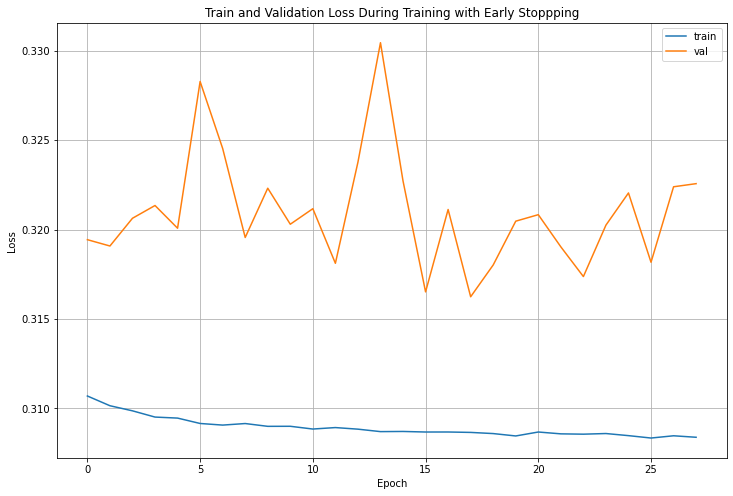

In [45]:
plt.figure(figsize = (12,8))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.grid(True)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Tuned Model Train and Validation Loss During Training with Early Stoppping")
plt.legend()
plt.show()

In [46]:
#Tuned Test Accuracy and F1 Scores
y_pred = model.predict(X_test_enc)
#Change the prediction to form expected for accuracy and f1-score functions
y_pred = np.round(y_pred.reshape((y_pred.shape[0])))
#Change the validation targets 
y_test = y_test.astype(np.int)
model_test_acc = np.round(accuracy_score(y_pred, y_test), 4) * 100
model_test_f1 = np.round(f1_score(y_pred, y_test), 4) * 100
print(f"Tuned Model Test Accuracy Score: {model_test_acc:.2f}%")
print(f"Tuned Model Test F1-Score: {model_test_f1:.2f}%")

Model Test Accuracy Score: 90.48%
Model Test F1-Score: 57.38%


In [47]:
#Confusion matrix
confusion_matrix(y_pred, y_test)

array([[131953,   9089],
       [  5854,  10060]], dtype=int64)

Let's see what the test results are for the baseline model. 

### Baseline Deep Learning Model

In [38]:
%%time
early = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 10, restore_best_weights=True)

history = baseline_model.fit(X_train_enc, y_train_enc, validation_split=.1, epochs=50, batch_size=32, verbose=0, callbacks = [early])

Restoring model weights from the end of the best epoch.
Epoch 00011: early stopping
Wall time: 20min 23s


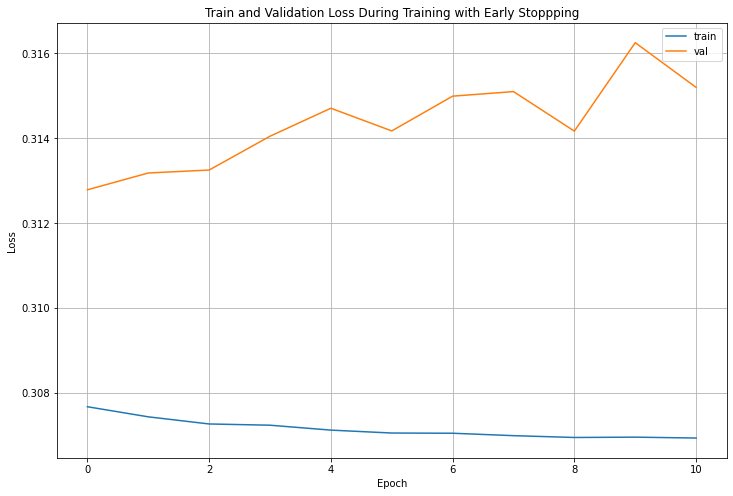

In [39]:
plt.figure(figsize = (12,8))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.grid(True)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Baseline Model Train and Validation Loss During Training with Early Stoppping")
plt.legend()
plt.show()

In [42]:
#Baseline Test Accuracy and F1 Scores
y_pred = baseline_model.predict(X_test_enc)
#Change the prediction to form expected for accuracy and f1-score functions
y_pred = np.round(y_pred.reshape((y_pred.shape[0])))
#Change the validation targets 
y_test = y_test.astype(np.int)
base_model_test_acc = np.round(accuracy_score(y_pred, y_test), 4) * 100
base_model_test_f1 = np.round(f1_score(y_pred, y_test), 4) * 100
print(f"Baseline Model Test Accuracy Score: {base_model_test_acc:.2f}%")
print(f"Baseline Model Test F1-Score: {base_model_test_f1:.2f}%")

Baseline Model Test Accuracy Score: 90.52%
Baseline Model Test F1-Score: 57.36%


In [43]:
#Confusion matrix
confusion_matrix(y_pred, y_test)

array([[132065,   9140],
       [  5742,  10009]], dtype=int64)

# Train on the Full Data

Since the baseline model performed just as well as the tuned model, we'll just use the baseline in production since inference will be much faster for new instances. 

In [83]:
%%capture --no-stdout
cd.chicago_data_cleaner(chicago, verbose=True)

Cleaning Started...

Successfully Cleaned Primary Type
Successfully Imputed Location
Successfully Cleaned Location
Successfully Added Month Column
Successfully Added Hour Column
Successfully Cleaned Community

Data Set Successfully Cleaned!


In [89]:
#Specify the features to use
features = ["primary_type", "location_description", "domestic", "district_name", "community_name", "Month", "Hour"]
#Transform the training features and targets into arrays
X, y = data_to_array(chicago, features)

In [92]:
#Encode the training and target features
X_enc, _ = prepare_inputs(X, X)
#Encode the training and validation targets
y_enc, _ = prepare_targets(y, y)

In [95]:
%%time
early = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 20, restore_best_weights=True)

history = baseline_model.fit(X_enc, y_enc, validation_split=.1, epochs=100, batch_size=32, verbose=0, callbacks = [early])

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Wall time: 1h 22min


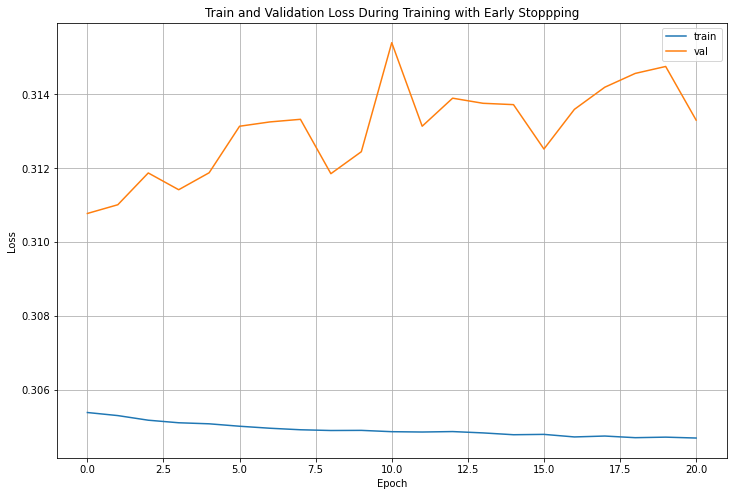

In [96]:
plt.figure(figsize = (12,8))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.grid(True)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train and Validation Loss During Training with Early Stoppping")
plt.legend()
plt.show()

In [97]:
#Save the model with the best hyperparameters
baseline_model.save("best_nn_model_fitted_h5", save_format="h5")